In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'../datasets/hospital_augment_train7.csv')

In [4]:
df.head()

,gen_data,true_data
0,-รงพยาบาลกรุงเทพพิษณุโลก,โรงพยาบาลกรุงเทพพิษณุโลก
1,.รงพยาบาลกะปงชัยพัฒน์,โรงพยาบาลกะปงชัยพัฒน์
2,(รงพยาบาลแกดำ,โรงพยาบาลแกดำ
3,(ลินิกเวชกรรมจุฬารัตน์4,คลินิกเวชกรรมจุฬารัตน์4
4,(้าน,บ้าน


In [5]:
df_new = df.sample(frac=1)
#df_new = df_new1.sample(frac=1)

In [6]:
hospital_gen_train = list(df_new['gen_data'])
hospital_true_train = list(df_new['true_data'])

In [7]:
df_test = pd.read_csv(r'../datasets/hospital_augment_test7.csv')

In [8]:
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [9]:
from pythainlp import thai_letters

In [10]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [11]:
char_set = label_map_0+label_map_1

In [12]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [13]:
count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [14]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [15]:
input_texts = []
target_texts = []

In [16]:
hospital_gen_train[:10]

['สถานพยาบาลจุฬารฆตน์1',
 'โรงพยาบาลวิเชียรบุรฐี',
 'โรงพยาบาลมงกุฎวศัฒนะ',
 'โรงพาบาลนครินทร์',
 'โรงพยใาบาลาบ่อเกลือ',
 'โรงปยาบาลบางนา 1',
 'โรงพยาบาลหนองแไผ่',
 'โรงพยาบาลกำแพงเพช',
 'โรงพกาบาลกาฬสินธุ์',
 'โรงพยาบาลฐิชชัน']

In [17]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i].replace('\u200b',''))
    target_texts.append(output_text.replace('\u200b',''))
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 93962


In [18]:
input_texts[0],target_texts[0]

('สถานพยาบาลจุฬารฆตน์1', '\tสถานพยาบาลจุฬารัตน์1\n')

In [19]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 78
Max Dec Len: 75


In [20]:
idx = int(len(input_texts)*0.1)

In [21]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32')
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32')
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32')
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [22]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((93962, 78, 93), (93962, 75, 93), (93962, 75, 93))

In [23]:
num_samples_val = idx
encoder_input_data_val = np.zeros( (num_samples_val , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data_val = np.zeros( (num_samples_val , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data_val = np.zeros( (num_samples_val , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [24]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [25]:
val_idx = len(input_texts)-idx

In [26]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts[val_idx:],target_texts[val_idx:])):
    for t,char in enumerate(input_text):
        encoder_input_data_val[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_val[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_val[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")   

COMPLETED...


In [27]:
len(input_texts),len(target_texts)

(93962, 93962)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate
import tensorflow as tf

In [29]:
batch_size = 256
epochs = 100
latent_dim = 128

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = Bidirectional(LSTM(latent_dim,return_state=True))
#encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
#encoder_outputs , state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h,state_c]
#encoder_states = [ forward_h, forward_c, backward_h, backward_c]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [30]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim*2,return_sequences=True,return_state=True)
#d_outputs, dh1, dc1 = decoder_lstm1(decoder_inputs,initial_state= encoder_states)
#decoder_lstm2 = LSTM(latent_dim*2,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

In [31]:
num_dec_tokens

93

In [32]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [33]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 227328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [34]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='loss', min_delta=0.0001,
  patience=20)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_v14.h5",
            save_best_only=True,
            monitor='loss',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [35]:
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 100,validation_split=0.1,
          batch_size = batch_size,callbacks=[earlystop_callback,saveModel_callback])

 saving model to models/bilstm_hosipital_v14.h5
84565/84565 [==============================] - 21s 245us/sample - loss: 0.2330 - val_loss: 0.1892
Epoch 4/100
84480/84565 [============================>.] - ETA: 0s - loss: 0.1562
Epoch 00004: loss improved from 0.23301 to 0.15624, saving model to models/bilstm_hosipital_v14.h5
84565/84565 [==============================] - 21s 243us/sample - loss: 0.1562 - val_loss: 0.1300
Epoch 5/100
84480/84565 [============================>.] - ETA: 0s - loss: 0.1095
Epoch 00005: loss improved from 0.15624 to 0.10950, saving model to models/bilstm_hosipital_v14.h5
84565/84565 [==============================] - 28s 335us/sample - loss: 0.1095 - val_loss: 0.0908
Epoch 6/100
84480/84565 [============================>.] - ETA: 0s - loss: 0.1010
Epoch 00006: loss improved from 0.10950 to 0.10092, saving model to models/bilstm_hosipital_v14.h5
84565/84565 [==============================] - 21s 248us/sample - loss: 0.1009 - val_loss: 0.0760
Epoch 7/100
84480

In [37]:
model.save('bilstm_v14')

INFO:tensorflow:Assets written to: bilstm_v14\assets


In [38]:
import matplotlib.pyplot as plt

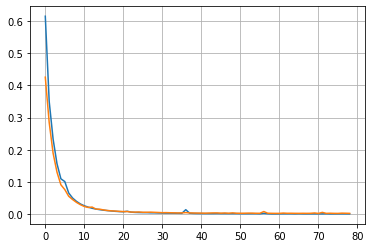

In [39]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.grid()

In [40]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v14.h5')
decoder_model.save('decoder_v14.h5')

In [41]:
model.save_weights('models/bilstm_v14')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
encoder_model = load_model('encoder_v8_new.h5',compile=False)

In [ ]:
decoder_model = load_model('decoder_v8_new.h5',compile=False)

In [42]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [ ]:
pred_sent_train = []
for seq_index in range(num_samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_train.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

In [47]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i].replace('\u200b',''))
    test_y.append(output_text.replace('\u200b',''))
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 8943


In [48]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 75
Max Dec Len: 75


In [49]:
##### Test Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [50]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [51]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

8943/8943 [==============================] - 4s 486us/sample - loss: 0.0069


0.006933015119555155

In [53]:
import time

In [54]:
start_time = time.time()
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    sent = str(''.join(lst))
    sent_2 = sent.strip('\n')
    print(seq_index)
    '''
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', sent_2)
    print('Ground Truth:',target_texts[seq_index])
    '''
print("--- %s seconds ---" % (time.time() - start_time))     


4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149

In [ ]:
import pickle
with open('char2int.pickle', 'wb') as handle:
    pickle.dump(char2int, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('int2char.pickle', 'wb') as handle:
    pickle.dump(int2char, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_y[0]

In [55]:
pred_test = []
for i,key in enumerate(pred_sent_test):
    b = key[:-1]
    sent = ''.join(b)
    pred_test.append(sent)
    print('Input:', test_x[i])
    print('Prediction:', sent)
    print('Ground truth:', test_y[i])

บาลสว่างอารมณ์

Input: โรจงพยาบาลสวี
Prediction: โรงพยาบาลตากลี
Ground truth: 	โรงพยาบาลสวี

Input: โรงพยาถบาลสหเวช
Prediction: โรงพยาบาลสหเวช
Ground truth: 	โรงพยาบาลสหเวช

Input: โรงพยาบาลสหัสฐขันธ์
Prediction: โรงพยาบาลสหัสขันธ์
Ground truth: 	โรงพยาบาลสหัสขันธ์

Input: โรงพยาบาลสฦงแคว
Prediction: โรงพยาบาลสองแคว
Ground truth: 	โรงพยาบาลสองแคว

Input: โรงพยาบาส่องดาว
Prediction: โรงพยาบาลส่องดาว
Ground truth: 	โรงพยาบาลส่องดาว

Input: โรูพยาบาลสองพี4น้อง
Prediction: โรงพยาบาลสองพี่น้อง
Ground truth: 	โรงพยาบาลสองพี่น้อง

Input: โรผงพยาบาลสัตหีกม10
Prediction: โรงพยาบาลสัตหีบกม10
Ground truth: 	โรงพยาบาลสัตหีบกม10

Input: โรงพยจบาลสันกำแฦง
Prediction: โรงพยาบาลสันกำแพง
Ground truth: 	โรงพยาบาลสันกำแพง

Input: โรงพยาบาลสัูทราย
Prediction: โรงพยาบาลสังทราย
Ground truth: 	โรงพยาบาลสันทราย

Input: โรงพยาฯาลสามโก้
Prediction: โรงพยาบาลสามโก้
Ground truth: 	โรงพยาบาลสามโก้

Input: โรงพยาดบาลสามโคก
Prediction: โรงพยาบาลสามโคก
Ground truth: 	โรงพยาบาลสามโคก

Input: โรกพยาบาลสามง่าม
Predictio

In [56]:
pred_test_df = pd.DataFrame(pred_test)

In [57]:
pred_test_df.columns = ['pred_test']

In [58]:
pred_test_df.to_csv('Predict_Test14.csv',index=False)

In [59]:
count =0
wrong_pred =[]
wrong_true =[]
wrong_input = []
for i,key in enumerate(test_y):
    test = key[1:-1]
    if test.replace(' ','') == pred_test[i].replace(' ',''):
        count += 1
    else:
        wrong_pred.append(pred_test[i])
        wrong_true.append(test)
        wrong_input.append(test_x[i])

In [60]:
count

7943

In [ ]:
count/1000

In [ ]:
count - len(test_y)

In [71]:
count/len(test_y)

0.9563904729956391

In [61]:
#### Incorrect sentence ####
for i,value in enumerate(wrong_input):
    print('Input:', wrong_input[i])
    print('Prediction:', wrong_pred[i])
    print('Gound Thrust:', wrong_true[i])
    print('-')

Input: โรงพยาบาลสทงพระ
Prediction: โรงพยาบาลสทรงพระ
Gound Thrust: โรงพยาบาลสทิงพระ
-
Input: โรงพยาบาลสมเด็จพระสังฆราชพฏญาณฤังวรเพื่อผู้สูงอายุ
Prediction: โรงพยาบาลสมเด็จพระประยากเรียงเขื่งนารุญจักษี
Gound Thrust: โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ
-
Input: โรงพยาบาเลสะเมิง
Prediction: โรงพยาบาลเสะเมิง
Gound Thrust: โรงพยาบาลสะเมิง
-
Input: โรงพยาบาลสฬนติสโุข
Prediction: โรงพยาบาลสุโดริส
Gound Thrust: โรงพยาบาลสันติสุข
-
Input: โรงพยาบาลสดนทราย
Prediction: โรงพยาบาลสินภา
Gound Thrust: โรงพยาบาลสันทราย
-
Input: โรงพยาบากลสามพราน
Prediction: โรงพยาบาลสมเด็จพระยุพราช
Gound Thrust: โรงพยาบาลสามพราน
-
Input: โรงพยาบาลสีชอพู
Prediction: โรงพยาบาลสีชัย
Gound Thrust: โรงพยาบาลสีชมพู
-
Input: โรงพยาบาลหนองมสูง
Prediction: โรงพยาบาลหนองมูง
Gound Thrust: โรงพยาบาลหนองสูง
-
Input: โรงพย8าบาลหริไภแุญชัยเมโมเรียล
Prediction: โรงพยาบาลหลวมินทร์เฉลิมพระเกียรติ 80 พรรษา
Gound Thrust: โรงพยาบาลหริภุญชัยเมโมเรียล
-
Input: โรงพึยาบาลห้นยกระซเจาซเฉลิมพระเกียรติ 80 พรรษา
Prediction: โรงพยาบาลห

In [ ]:
wrong_pred[3],wrong_input[3],wrong_true[3]

In [73]:
if 'โรงพยาบาลเกษมราษฎร์' in hospital_true_test:
    print('vao')

In [79]:
df_wrong_input = pd.DataFrame(wrong_input)
df_wrong_true = pd.DataFrame(wrong_true)

In [80]:
df_wrong_input.columns=['gen_data']
df_wrong_true.columns=['true_data']

In [81]:
df_col_merged =pd.concat([df_wrong_input,df_wrong_true],axis=1)

In [83]:
df_col_merged.to_csv('hospital_wrong13.csv',index=False)

In [ ]:
from char_error_rate import get_char_error_rate

In [ ]:
def createSpace_for_cer(text):
    re = []
    for t in text :
        re.append(t)
        
    #re.append("<eow>")
    #pad_list = ["<pad>"]*(max_seq-len(re)+index)
    #re_pad = re + pad_list
    return re

In [ ]:
pred_test_output = []
for txt in pred_test:
    pred_test_output.append(createSpace_for_cer(txt))

In [ ]:
ground_test =[]
for txt in test_y[:1000]:
    ground_test.append(createSpace_for_cer(txt))

In [ ]:
input_test = []
for txt in test_x[:1000]:
    input_test.append(createSpace_for_cer(txt))

In [ ]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],pred_test_output[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

In [ ]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],input_test[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

In [ ]:
test_x[50],test_y[50]

In [ ]:
pred_sent_test[50]

In [ ]:
text50 = ''.join(pred_sent_test[50])
text50

In [ ]:
input_seq = encoder_input_data_test[50:51]

In [ ]:
input_seq.shape

In [ ]:
input_seq[0,0,:]

In [ ]:
states_value = encoder_model.predict(input_seq)

In [ ]:
states_value[0].shape

In [ ]:
states_value[1].shape

In [ ]:
target_seq = np.zeros((1, 1, num_dec_tokens))

In [ ]:
target_seq.shape

In [ ]:
target_seq[0, 0, char2int['\t']] = 1

In [ ]:
target_seq

In [ ]:
out = [target_seq]+states_value
len(out)

In [ ]:
output_tokens,h,c = decoder_model.predict([target_seq] + states_value)

In [ ]:
sampled_token_index = np.argmax(output_tokens[0, -1, :])

In [ ]:
np.argmax(output_tokens[0,-1,:])

In [ ]:
stop_condition = False
decoded_sentence = ''
decoded_list =[]
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = int2char[sampled_token_index]
    decoded_sentence += sampled_char
    
    decoded_list.append(sampled_char)
    print('Decoder seq:{}'.format(''.join(decoded_list)))
    print('Character:{}'.format(sampled_char))

    # Exit condition: either hit max length
    # or find stop character.
    if (sampled_char == '\n' or len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_dec_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

        # Update states
    states_value = [h, c]

In [63]:
df_6 = pd.read_csv('../datasets/hospital_augment_train6_3.csv')

In [65]:
df_64 = df_6.sample(frac=1)

In [68]:
dfs = list(df_64['gen_data'])

In [69]:
dfs[-1]

'โรโยาบาลสมเ็จพระยเพราชเดชอุดม'

In [70]:
df_64.to_csv('../datasets/hospital_augment_train6_4.csv',index=False)